In [44]:
import sys
print(sys.path)
import seaborn as sns
sns.set()

['', '/opt/conda/lib/python36.zip', '/opt/conda/lib/python3.6', '/opt/conda/lib/python3.6/lib-dynload', '/opt/conda/lib/python3.6/site-packages', '/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/opt/conda/lib/python3.6/site-packages/IPython/extensions', '/home/yukimiki/.ipython', '/tmp/fastai/old']


In [45]:
sys.path.append("/tmp/fastai/old")

In [46]:
import fastai

In [47]:
from fastai.conv_learner import *

In [48]:
from fastai.dataset import *

In [49]:
from datetime import datetime
import pandas as pd
import numpy as np
np.random.seed(seed=32)
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
#from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
from tensorboard_cb import TensorboardLogger
import torch
torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
import utils_pytorch

In [50]:
nw = 20   #number of workers for data loader
arch = resnet34 #specify target architecture

In [51]:
train_names = list({f[:36] for f in os.listdir(utils_pytorch.TRAIN)})
test_names = list({f[:36] for f in os.listdir(utils_pytorch.TEST)})
# tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

data_info = pd.read_csv(utils_pytorch.LABELS)
tr_n, val_n = train_test_split(data_info, test_size = 0.1, 
                 stratify = data_info['Target'].map(lambda x: x[:3] if '27' not in x else '0'), random_state=42)
tr_n = tr_n['Id'].tolist()
val_n = val_n['Id'].tolist()

In [52]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(45, tfm_y=TfmType.NO),
                RandomFlip(),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    stats = A([0.0868 , 0.05959, 0.06522, 0.08891], [0.13044, 0.09792, 0.14862, 0.13281])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(utils_pytorch.pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],utils_pytorch.TRAIN), 
                (val_n,utils_pytorch.TRAIN), tfms, test=(test_names,utils_pytorch.TEST))
    md = ImageData(utils_pytorch.PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [53]:
sz = 512 #image size
bs = 64  #batch size

dir_name = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
print(dir_name)
dir_path = os.path.join('test', dir_name)
best_model_path = dir_name + 'best_resnet'


md = get_data(sz,bs)
learner = utils_pytorch.ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
#pretrained_model_name = '20181129055744_size256best_resnet' # 299
pretrained_model_name = '20181129122117best_resnet' # 512
learner.load(pretrained_model_name)
learner.set_data(md)

learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = utils_pytorch.FocalLoss()
learner.metrics = [utils_pytorch.acc, utils_pytorch.f1_torch]
tb_logger = TensorboardLogger(learner.model, md, dir_path, metrics_names=['acc', 'f1'])
#save_best_model = SaveBestModel(model=learner.model)

20181129235410


In [54]:
#learner.summary

epoch      trn_loss   val_loss   acc        f1_torch   
    0      0.66245    0.680068   0.968319   0.41908   


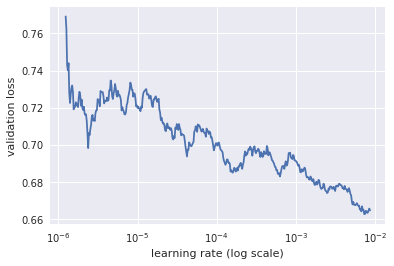

In [58]:
learner.lr_find(start_lr=1e-6, end_lr=1e-2)
#learner.lr_find()
learner.sched.plot()

In [13]:
lr = 1e-4
learner.fit(lr,1, best_save_name=best_model_path, callbacks=[tb_logger])

epoch      trn_loss   val_loss   acc        f1_torch   
    0      0.513041   0.578464   0.972835   0.590556  



[0.5784640441453288, 0.9728351228485697, 0.5905557838646142]

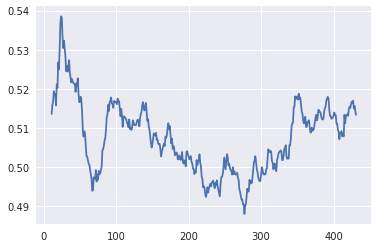

In [14]:
learner.sched.plot_loss()

In [15]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [16]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20), best_save_name=best_model_path, callbacks=[tb_logger])

epoch      trn_loss   val_loss   acc        f1_torch   
    0      0.507742   0.562082   0.973341   0.599375  
    1      0.501826   0.562233   0.973743   0.621087  
    2      0.509742   0.557954   0.974122   0.608837  
    3      0.498957   0.557828   0.973961   0.609764  
    4      0.49494    0.556316   0.973835   0.610158  
    5      0.487888   0.555065   0.973938   0.611166  
    6      0.500119   0.555924   0.973915   0.621058  
    7      0.494173   0.55479    0.973823   0.61965   



[0.5547897249575288, 0.9738233601111089, 0.6196496704523782]

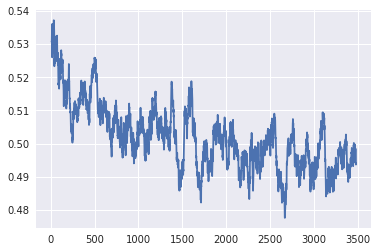

In [17]:
learner.sched.plot_loss()

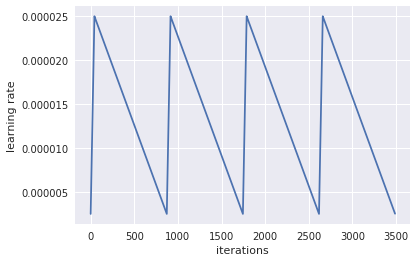

In [18]:
learner.sched.plot_lr()

In [19]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20), best_save_name=best_model_path, callbacks=[tb_logger])

epoch      trn_loss   val_loss   acc        f1_torch   
    0      0.488794   0.554867   0.974088   0.619864  
    1      0.491557   0.55368    0.973961   0.614344  
    2      0.48711    0.552267   0.974111   0.61204   
    3      0.486407   0.553202   0.974088   0.617397  
    4      0.500629   0.554316   0.974134   0.618913  
    5      0.494511   0.553321   0.974157   0.619864  
    6      0.482271   0.554445   0.973938   0.61408   
    7      0.490024   0.552257   0.974306   0.61511   



[0.5522572414678649, 0.9743059840595093, 0.6151099333891997]

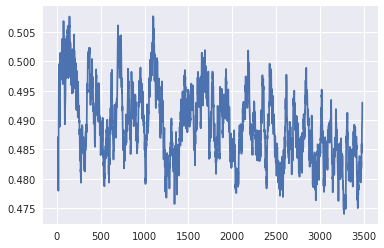

In [20]:
learner.sched.plot_loss()

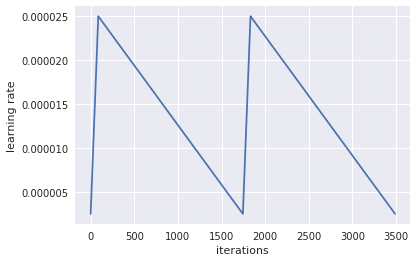

In [21]:
learner.sched.plot_lr()

In [22]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20), best_save_name=best_model_path, callbacks=[tb_logger])

epoch      trn_loss   val_loss   acc        f1_torch   
    0      0.473276   0.552151   0.974375   0.619883  
    1      0.48333    0.552589   0.974467   0.628956  
    2      0.489785   0.553579   0.973927   0.620486  
    3      0.480215   0.551769   0.974203   0.614037  
    4      0.486873   0.552456   0.974088   0.612632  
    5      0.472595   0.555033   0.974157   0.629063  
    6      0.480545   0.553722   0.974203   0.6197    
    7      0.482118   0.553477   0.974214   0.621073  



[0.553477345171122, 0.9742140477688617, 0.6210730378845637]

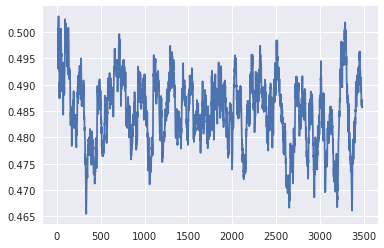

In [23]:
learner.sched.plot_loss()

In [24]:
learner.save('ResNet34_256_1')

In [25]:
learner.load(best_model_path)

In [26]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [27]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(utils_pytorch.name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [28]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.54525 0.60835 0.60071 0.58816 0.59703 0.58646 0.56084 0.63054 0.51671 0.62436 0.64099 0.5541  0.64991
 0.5345  0.54019 0.60742 0.49698 0.52646 0.5182  0.55603 0.5129  0.53808 0.5477  0.62574 0.59252 0.51107
 0.61261 0.27006]
F1 macro:  0.7051545398139956
F1 macro (th = 0.5):  0.6539140361162403
F1 micro:  0.7725076422443546


In [29]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.46203 0.03314 0.10586 0.04054 0.05373 0.06403 0.02252 0.07529 0.00161 0.00129 0.00097 0.03797 0.01609
 0.01287 0.03443 0.00032 0.0119  0.00644 0.0296  0.04086 0.00322 0.1258  0.01802 0.08494 0.01062 0.33172
 0.00644 0.00129]
Fractions (true):  [0.42535 0.03861 0.11776 0.04923 0.05856 0.07497 0.03185 0.08784 0.00129 0.00161 0.00097 0.03539 0.0222
 0.01544 0.03636 0.00064 0.01673 0.00804 0.03024 0.04698 0.00547 0.12323 0.02574 0.09299 0.0103  0.26062
 0.01062 0.00032]


In [30]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [31]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(utils_pytorch.SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(os.path.join('logs', dir_path, fname), header=True, index=False)

In [32]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.44095 0.05315 0.10485 0.08452 0.10015 0.13733 0.0723  0.11784 0.00248 0.00145 0.00128 0.05973 0.06674
 0.02547 0.04615 0.00043 0.047   0.03059 0.0476  0.09887 0.01051 0.19227 0.04341 0.13827 0.01547 0.34968
 0.05375 0.03734]


In [33]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))

Thresholds:  [0.565 0.39  0.55  0.345 0.33  0.39  0.33  0.45  0.38  0.39  0.34  0.42  0.31  0.38  0.49  0.5   0.38  0.43
 0.46  0.4   0.39  0.505 0.37  0.47  0.41  0.545 0.32  0.1  ]
F1 macro:  0.5663324495854832
F1 macro (th = 0.5):  0.6539140361162403
F1 micro:  0.6832885195143812


In [34]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [35]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(utils_pytorch.name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [36]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.6456  0.45645 0.65272 0.40673 0.38489 0.49611 0.40418 0.56509 0.21734 0.2025  0.15412 0.50176 0.37598
 0.50056 0.51018 0.22106 0.44714 0.57837 0.52461 0.48976 0.3998  0.59147 0.43926 0.62523 0.53337 0.63354
 0.401   0.17334]
Fractions:  [0.36447 0.04298 0.07486 0.05734 0.07324 0.07324 0.04179 0.07469 0.0088  0.0088  0.00803 0.04324 0.04222
 0.01401 0.04367 0.00812 0.02709 0.01436 0.02752 0.0576  0.00949 0.12613 0.02794 0.07426 0.00966 0.21979
 0.02658 0.00658]
Fractions (th = 0.5):  [0.50342 0.03914 0.12588 0.03675 0.04247 0.07161 0.02444 0.09571 0.00085 0.0006  0.00017 0.04341 0.02128
 0.01401 0.04478 0.00043 0.01974 0.02119 0.03299 0.05478 0.00385 0.19697 0.01948 0.12271 0.01162 0.42001
 0.01444 0.00009]


In [37]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))

Thresholds:  [0.6456  0.45645 0.65272 0.40673 0.38489 0.49611 0.40418 0.56509 0.21734 0.2025  0.15412 0.50176 0.37598
 0.50056 0.51018 0.22106 0.44714 0.57837 0.52461 0.48976 0.3998  0.59147 0.43926 0.62523 0.53337 0.63354
 0.401   0.17334]
F1 macro:  0.5562752804778635
F1 macro (th = 0.5):  0.6539140361162403
F1 micro:  0.7161460883188093


In [38]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [39]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.5,'protein_classification_05.csv')

In [40]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [41]:
labels = pd.read_csv(utils_pytorch.LABELS).set_index('Id')
label_count = np.zeros(len(utils_pytorch.name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(utils_pytorch.name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [42]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

Thresholds:  [0.59269 0.48811 0.52499 0.43812 0.42863 0.48399 0.45319 0.51682 0.41291 0.41435 0.40325 0.56573 0.4991
 0.45644 0.61972 0.43102 0.52129 0.68652 0.52366 0.52586 0.46458 0.59807 0.45776 0.5649  0.52483 0.60262
 0.54167 0.3479 ]
Fractions:  [0.4148  0.03982 0.11494 0.0488  0.05854 0.07862 0.03187 0.08904 0.00145 0.00128 0.00094 0.03512 0.02145
 0.01658 0.03444 0.0006  0.01675 0.00649 0.02794 0.04555 0.00538 0.1216  0.02521 0.09383 0.01017 0.26346
 0.01008 0.00034]


In [43]:
print('Thresholds: ',th_t)
print('F1 macro: ',f1_score(y, pred>th_t, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th_t, average='micro'))

Thresholds:  [0.59269 0.48811 0.52499 0.43812 0.42863 0.48399 0.45319 0.51682 0.41291 0.41435 0.40325 0.56573 0.4991
 0.45644 0.61972 0.43102 0.52129 0.68652 0.52366 0.52586 0.46458 0.59807 0.45776 0.5649  0.52483 0.60262
 0.54167 0.3479 ]
F1 macro:  0.6268496682751582
F1 macro (th = 0.5):  0.6539140361162403
F1 micro:  0.7458259673934394
